# Data Download

In [1]:
import pandas as pd
import requests
from tqdm import tqdm
import time
from datetime import datetime, timedelta
last_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
from dotenv import load_dotenv
import matplotlib.pyplot as plt
load_dotenv()
etherscan_api_key = 'K19SX6W3FFTM8JC5RRGCABJTP2AKY1AVDA'

def data_query(token_address, last_date, api_key):
    start_block = 0
    end_block = 99999999999
    storage = []
    dt = datetime.strptime(last_date, '%Y-%m-%d')
    current_time = 0
    
    with tqdm(total=int(dt.timestamp())) as pbar:  # Create progress bar
        while current_time < int(dt.timestamp()):
            url = f'http://api.etherscan.io/api?module=account&action=tokentx&' \
                  f'contractaddress={token_address}&' \
                  f'startblock={start_block}&endblock={end_block}&sort=asc&apikey={api_key}'
            response = requests.get(url)
            print(response.status_code)
            if response.status_code== 200:
                print(url)
                
                tempt_output = pd.DataFrame(response.json()['result'])
                storage.append(tempt_output)
                start_block = int(tempt_output['blockNumber'].astype(float).max())
                new_time = int(tempt_output['timeStamp'].max())  # Get the new time first
            
                # Update progress bar by the difference between new time and old time
                pbar.update(new_time - current_time)
                current_time = new_time
            
                #storage.append(tempt_output)
            else:
                time.sleep(3)
            
            time.sleep(3)
    output = pd.concat(storage)
    return output

In [2]:
token_address = '0x4da27a545c0c5b758a6ba100e3a049001de870f5' #aave
etherscan_output = data_query(token_address = token_address, last_date = last_date, api_key=etherscan_api_key)

  0%|          | 0/1706313600 [00:05<?, ?it/s]


KeyboardInterrupt: 

# Data processing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pygini import gini

# Step 1: Read the CSV file
df = pd.read_csv('aave.csv')

# Step 2: Convert timestamp to readable date
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')

# Convert 'value' to numeric
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Identify user address (not the contract address) and treat value as positive for 'to' and negative for 'from'
contract_address = '0x0000000000000000000000000000000000000000'  # Replace with the actual contract address
df['user_address'] = df.apply(lambda x: x['to'] if x['contractAddress'] == contract_address else x['from'], axis=1)
df['stake_change'] = df.apply(lambda x: -x['value'] if x['to'] == x['user_address'] else x['value'], axis=1)

TOP_N = len(df['user_address'].unique())  # Set TOP_N to the number of unique user addresses

# Exclude the contract address from the aggregation
df = df[df['user_address'] != contract_address]

# Aggregate data
df_agg = df.groupby(['user_address', df['timeStamp'].dt.date])['stake_change'].sum().reset_index()

# Step 3: Calculate the cumulative stake
df_agg['cumulative_stake'] = df_agg.groupby('user_address')['stake_change'].cumsum()

# Step 4: Identify top stakers and group others
top_stakers = df_agg.groupby('user_address')['cumulative_stake'].max().nlargest(TOP_N).index
df_agg['user_address'] = df_agg['user_address'].where(df_agg['user_address'].isin(top_stakers), 'Others')

# Plotting

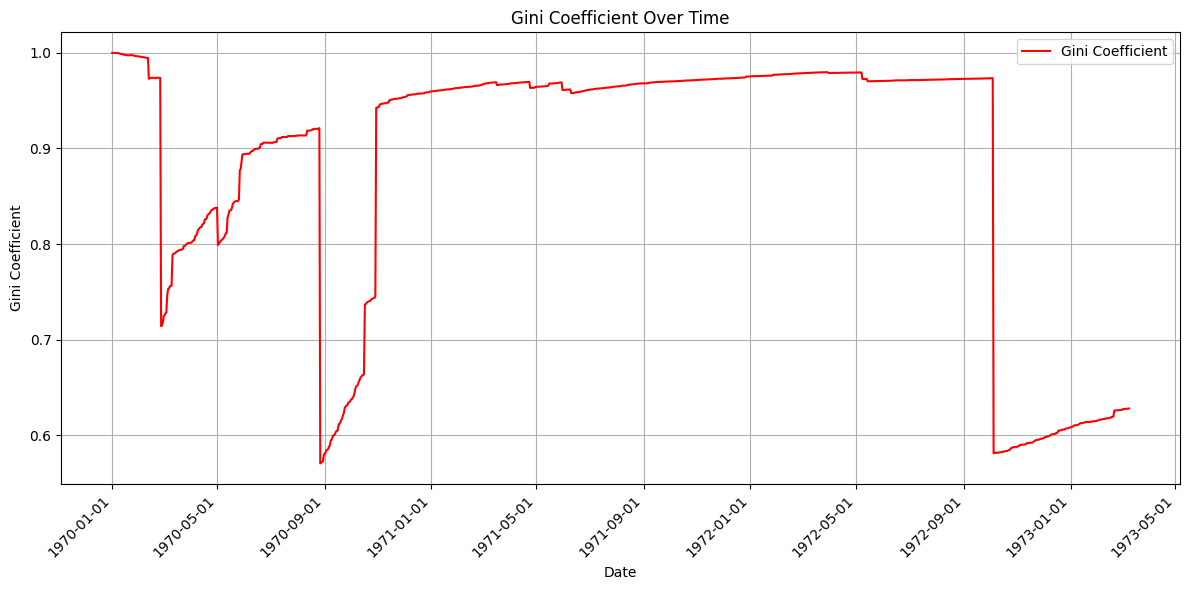

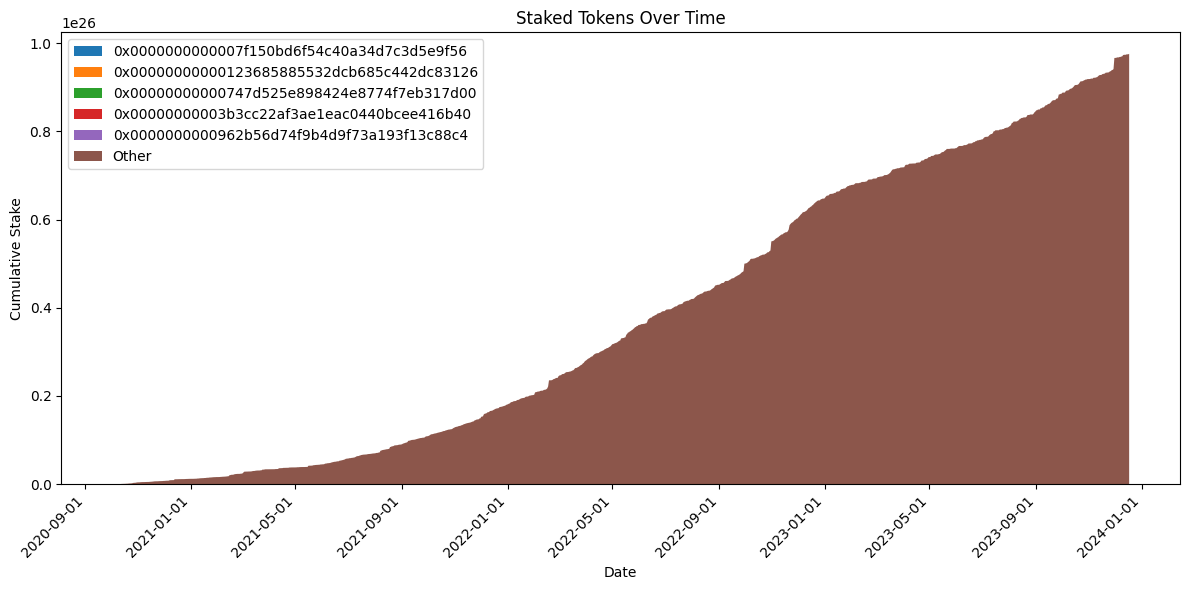

In [ ]:
df_agg = pd.read_csv('data/tvl/aave_agg.csv')

# Prepare data for plotting
pivot_data = df_agg.pivot_table(index='timeStamp', columns='user_address', values='cumulative_stake', aggfunc='sum', fill_value=0)
pivot_data = pivot_data.cumsum()

# Function to calculate Gini coefficient
def calculate_gini(df):
    if df.empty:
        return 0
    return gini(df.values)

# Calculate Gini coefficient for each timestamp
gini_coefficients = pivot_data.apply(calculate_gini, axis=1)

# Gini coefficient plot (assuming 'calculate_gini' function is defined and 'gini_coefficients' is calculated)
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(gini_coefficients.index, gini_coefficients.values, label='Gini Coefficient', color='r')
plt.title('Gini Coefficient Over Time')
plt.xlabel('Date')
plt.ylabel('Gini Coefficient')

# Set x-axis major locator to reduce date frequency and format the date
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Automatically format x-axis labels to fit nicely
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Keep the first 5 addresses and sum the rest into 'Other'
top_5_addresses = pivot_data.columns[:5]
other_addresses = pivot_data.columns[5:]
pivot_data['Other'] = pivot_data[other_addresses].sum(axis=1)
pivot_data = pivot_data[top_5_addresses.tolist() + ['Other']]

# Convert index to datetime for better control on matplotlib date formatting
pivot_data.index = pd.to_datetime(pivot_data.index)

# Plot
plt.figure(figsize=(12, 6), dpi=100)
plt.stackplot(pivot_data.index, pivot_data.T, labels=pivot_data.columns, edgecolor='none')
plt.title('Staked Tokens Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Stake')
plt.legend(loc='upper left')

# Set x-axis major locator to reduce date frequency and format the date
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Automatically format x-axis labels to fit nicely
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

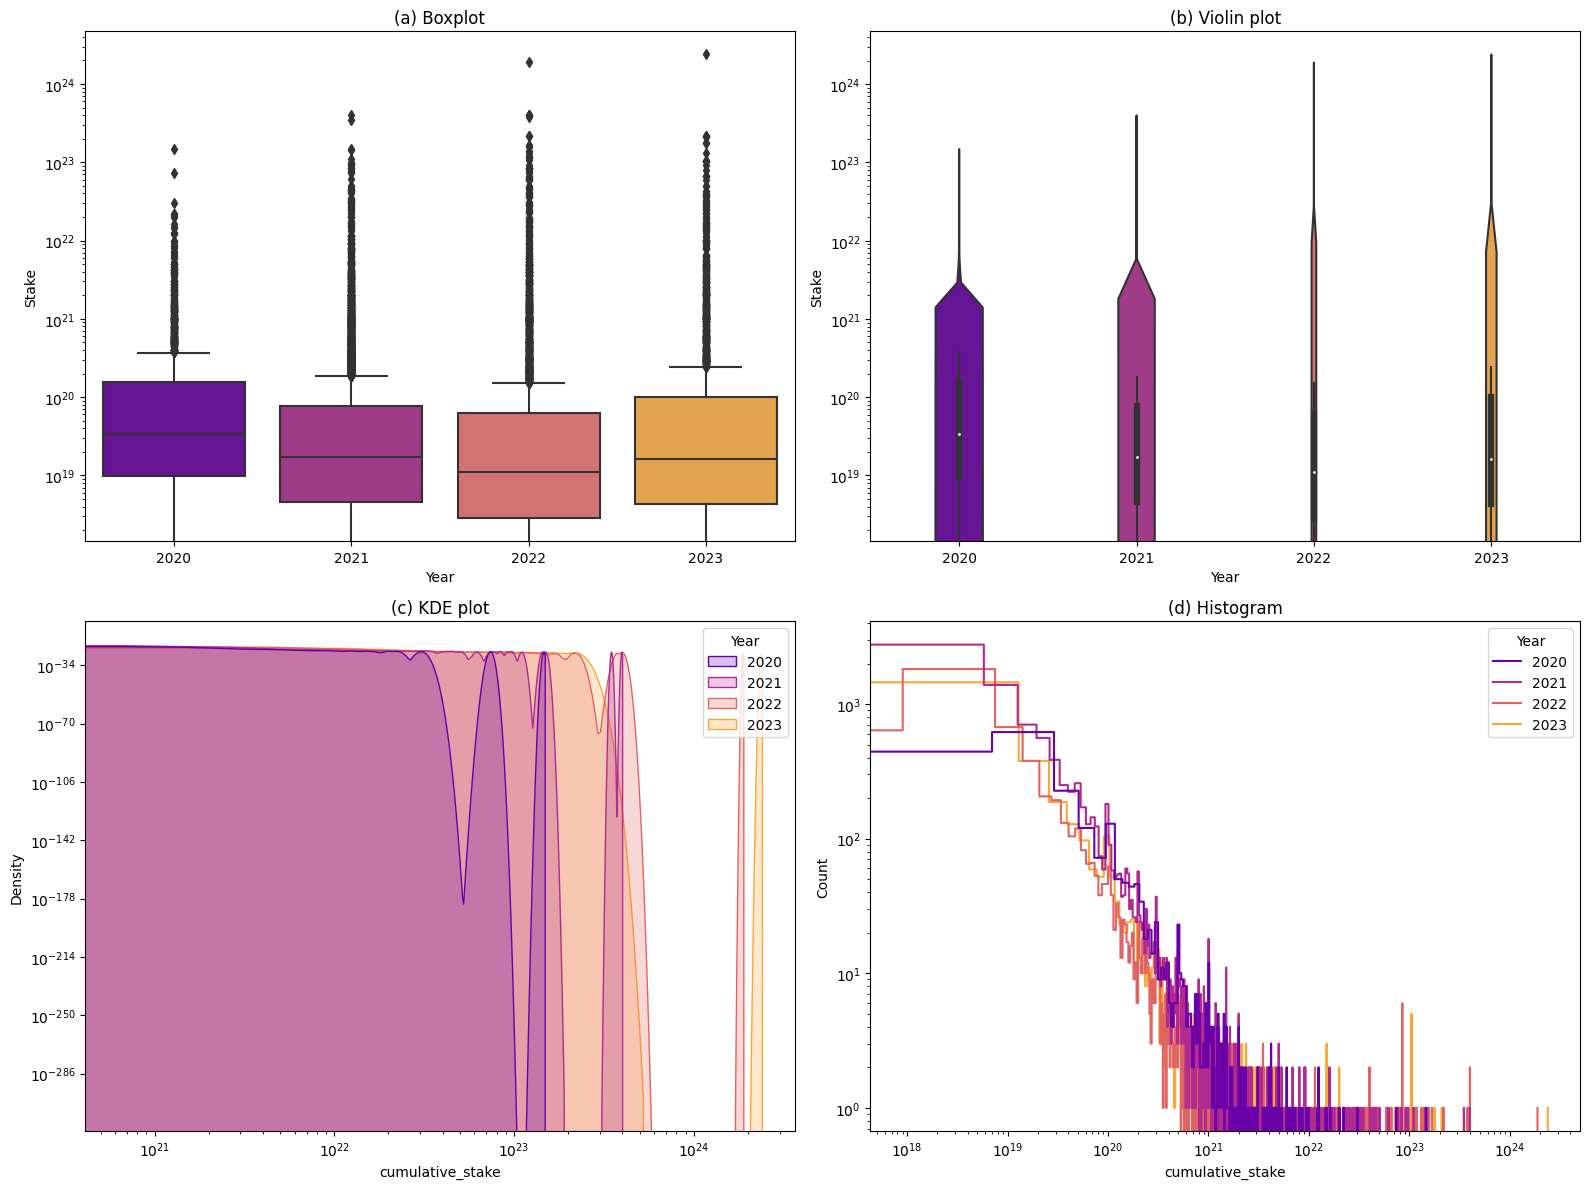

In [ ]:
import seaborn as sns

df_agg['Year'] = pd.to_datetime(df_agg['timeStamp']).dt.year

# Step 2: Get the last cumulative_stake for each user_address per year
yearly_data = df_agg.groupby(['user_address', 'Year'])['cumulative_stake'].last().reset_index()

# Step 3: Transform data for plotting
melted_yearly_data = yearly_data.melt(id_vars=['user_address', 'Year'], var_name='Type', value_name='Stake')

# Step 4: Creating subplots
plt.figure(figsize=(16, 12))

# Define a color palette
palette = sns.color_palette("plasma", n_colors=len(melted_yearly_data['Year'].unique()))

# Boxplot
ax1 = plt.subplot(2, 2, 1)
sns.boxplot(x='Year', y='Stake', data=melted_yearly_data, palette=palette)
ax1.set_title('(a) Boxplot')
ax1.set_yscale('log')

# Violin plot
ax2 = plt.subplot(2, 2, 2)
sns.violinplot(x='Year', y='Stake', data=melted_yearly_data, palette=palette)
ax2.set_title('(b) Violin plot')
ax2.set_yscale('log')

# KDE plot
ax3 = plt.subplot(2, 2, 3)
sns.kdeplot(data=yearly_data, x='cumulative_stake', hue='Year', fill=True, palette=palette)
ax3.set_title('(c) KDE plot')
ax3.set_xscale('log')
ax3.set_yscale('log')

# Histogram
ax4 = plt.subplot(2, 2, 4)
sns.histplot(data=yearly_data, x='cumulative_stake', hue='Year', element='step', fill=False, common_norm=False, common_bins=False, palette=palette)
ax4.set_title('(d) Histogram')
ax4.set_xscale('log')
ax4.set_yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

# Test Script

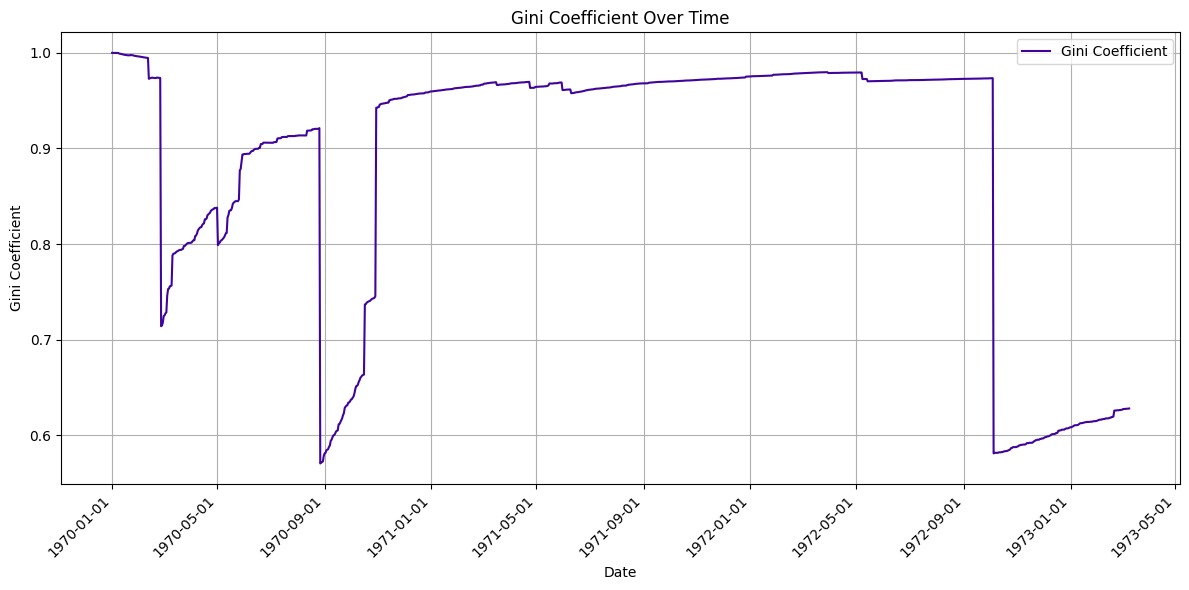

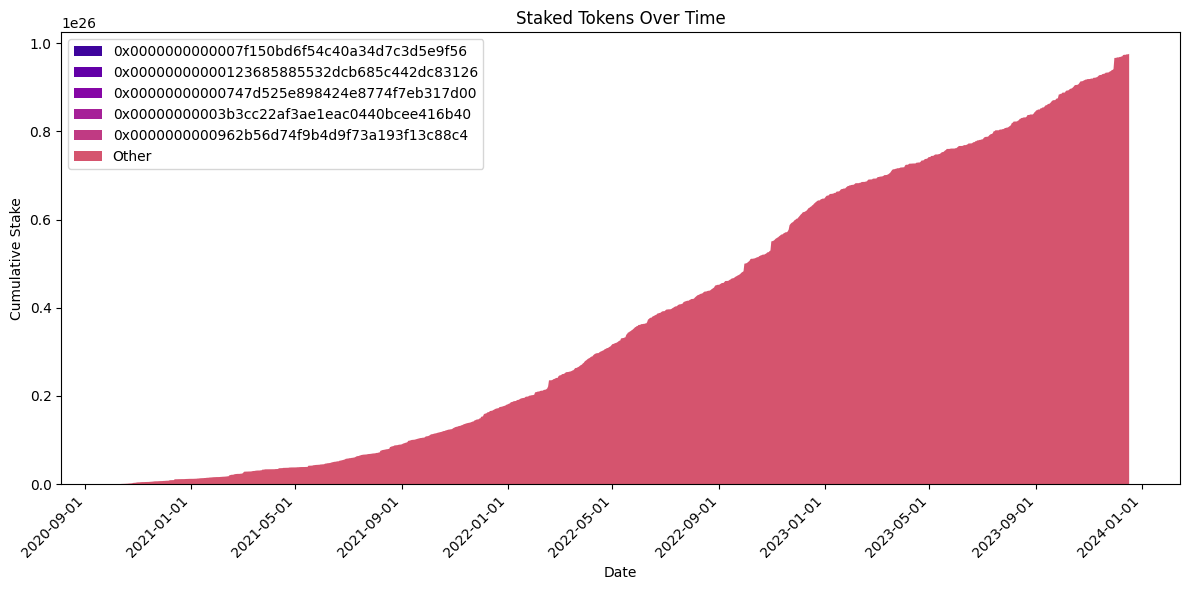

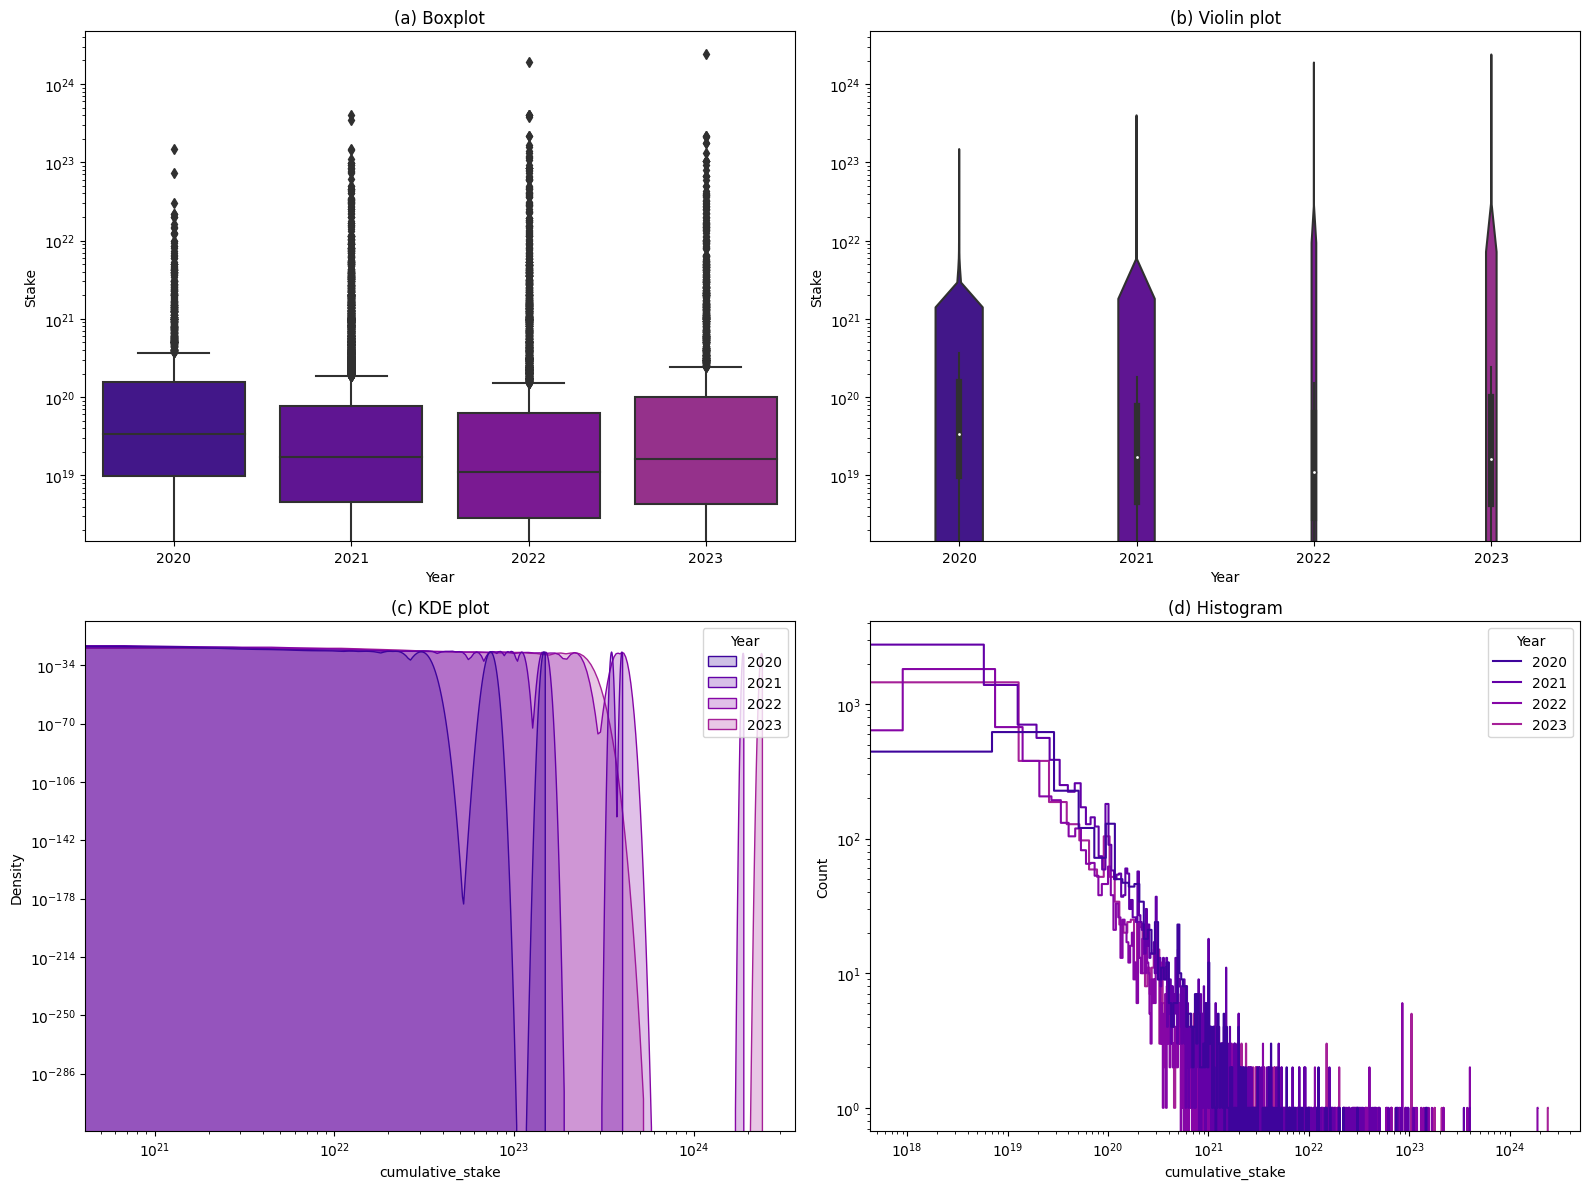

In [ ]:
from config.plotting_governance import TokenDistributionVisualizer

visualizer = TokenDistributionVisualizer('data/tvl/aave_agg.csv')
visualizer.calculate_gini_coefficients()
visualizer.plot_gini_coefficients()
visualizer.aggregate_top_addresses()
visualizer.plot_staked_tokens()
visualizer.plot_yearly_distribution()

# Markdown

In [ ]:
import pandas as pd
from config.query import BigQueryClient

bq_client = BigQueryClient()

TABLES = {
    'A': 'A_protocols',
    'B': 'B_protocol_chain_tvl',
    'C': 'C_protocol_token_tvl',
    'D': 'D_protocol_tvl',
    'E': 'E_chain_ndc_tvl'
}

def fetch_sample_data(bq_client, table_names, limit=5):
    """Fetch sample data from specified tables and return as a DataFrame."""
    sample_data = pd.DataFrame()

    for table_name in table_names:
        df = bq_client.get_dataframe(table_name, limit=limit)
        df['table_name'] = table_name  # Add a column to identify the table
        sample_data = sample_data.append(df, ignore_index=True)

    return sample_data

if __name__ == '__main__':
    bq_client = BigQueryClient()
    table_names = list(TABLES.values())  # Assuming TABLES is a dictionary of table names

    # Fetch sample data
    sample_data_df = fetch_sample_data(bq_client, table_names)

    # Save to CSV file
    output_file_path = 'sample_bigquery_data.csv'  # Adjust path as needed
    sample_data_df.to_csv(output_file_path, index=False)
    
    print(f"Sample data saved to {output_file_path}")


/tmp/ipykernel_5356/2077806039.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_data = sample_data.append(df, ignore_index=True)
/tmp/ipykernel_5356/2077806039.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_data = sample_data.append(df, ignore_index=True)
/tmp/ipykernel_5356/2077806039.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_data = sample_data.append(df, ignore_index=True)
/tmp/ipykernel_5356/2077806039.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_data = sample_data.append(df, ignore_index=True)


Sample data saved to sample_bigquery_data.csv


/tmp/ipykernel_5356/2077806039.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_data = sample_data.append(df, ignore_index=True)


# Migrate: BigQuery -> MotherDuck

In [ ]:
import pandas as pd
from config.query import BigQueryClient
from config.config import TABLES

# Initialize the BigQuery client
bq_client = BigQueryClient()

# Loop through each table in the TABLES dictionary
for table_key, table_name in TABLES.items():
    if table_key == 'C':
        continue
    print(f"Downloading {table_name}...")

    # Fetch the entire table as a DataFrame
    df = bq_client.get_dataframe(table_name)

    # Construct the file path for the Parquet file
    parquet_file_path = f"{table_name}.parquet"

    # Save the DataFrame as a Parquet file
    df.to_parquet(parquet_file_path)

    print(f"Saved {table_name} to {parquet_file_path}")

Saved A_protocols to A_protocols.parquet
Saved B_protocol_chain_tvl to B_protocol_chain_tvl.parquet


: 

In [1]:
import pandas as pd
from config.query import BigQueryClient
from config.config import TABLES

# Initialize the BigQuery client
bq_client = BigQueryClient()
bq_client.compare_months('2021', '7', '2021', '8')

,id,chain_name,token_name,year_month,avg_quantity,avg_value_usd
0,259,Avalanche-staking,IME-WAVAX-PGL,2021-07-01,0.000000,0.000000
1,318,OKExChain,WEXPOLY,2021-07-01,3.595810,0.005612
2,343,Moonriver,VC,2021-07-01,0.000000,0.000000
3,343,Canto-borrowed,GMD,2021-07-01,0.000000,0.000000
4,343,Arbitrum-borrowed,PBTC,2021-07-01,0.000000,0.000000
...,...,...,...,...,...,...
129574,121,Polygon-borrowed,FTX Token,2021-07-01,4740.774640,134922.446253
129575,111,Polygon-borrowed,AVAX,2021-07-01,0.000000,0.000000
129576,123,Polygon-borrowed,xAMZN,2021-07-01,0.903226,0.000000
129577,434,Polygon-borrowed,LUSD,2021-07-01,0.000000,0.000000
